In [ ]:
!pip install lightgbm

In [174]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
import seaborn as sns
from dateutil.parser import parse
import pickle

from sklearn.linear_model import LinearRegression
from lightgbm.sklearn import LGBMRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt

In [175]:
train = pd.read_csv('Train_Zindi.csv')                # Using Train as the complete data , to apply train-test split
riders = pd.read_csv('Riders_Zindi.csv')   

In [176]:
# Null count and Shape ,  train

print('Null count for each column :')                                           
print(train.isnull().sum())
print('The shape of the dataframe is' + ' ', train.shape)

Null count for each column :
Order No                                         0
User Id                                          0
Vehicle Type                                     0
Platform Type                                    0
Personal or Business                             0
Placement - Day of Month                         0
Placement - Weekday (Mo = 1)                     0
Placement - Time                                 0
Confirmation - Day of Month                      0
Confirmation - Weekday (Mo = 1)                  0
Confirmation - Time                              0
Arrival at Pickup - Day of Month                 0
Arrival at Pickup - Weekday (Mo = 1)             0
Arrival at Pickup - Time                         0
Pickup - Day of Month                            0
Pickup - Weekday (Mo = 1)                        0
Pickup - Time                                    0
Arrival at Destination - Day of Month            0
Arrival at Destination - Weekday (Mo = 1)        0
Ar

In [177]:
# Null count and Shape ,  riders

print('Null count for each column :')                                           
print(riders.isnull().sum())
print('The shape of the dataframe is' + ' ', riders.shape)

Null count for each column :
Rider Id          0
No_Of_Orders      0
Age               0
Average_Rating    0
No_of_Ratings     0
dtype: int64
The shape of the dataframe is  (960, 5)


In [178]:
riders.head()

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156


In [179]:
# Merge train and riders

data = pd.merge(train, riders, how='left', left_on='Rider Id', right_on='Rider Id', left_index=True)

In [180]:
data.head(3)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
27,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
739,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
851,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114


#### Feature Engineering

In [181]:
# Apply to test as well when creating submission file ( Dropping obvious columns )

data = data.drop(['Vehicle Type','Precipitation in millimeters' , 'User Id','Order No',
                 'Rider Id' ,'Arrival at Destination - Day of Month',
                 'Arrival at Destination - Weekday (Mo = 1)',
                 'Arrival at Destination - Time'],axis = 1)      # Drop Precipitation
data = data.fillna(data.mean())                                # Populate temperature nulls with median ( Justify this )

In [182]:
# Time manipulation functions

def time_parse_hr(time) :
    dt = parse(time)
    hour = dt.hour
    
    return hour

def time_parse_min(time) :
    dt = parse(time)
    minute = dt.minute
    
    return minute

def time_parse_sec(time) :
    dt = parse(time)
    second = dt.second
    
    return second

In [183]:
# Time manipulation application , Note: This is slow , search for alternative implementation

data['Placement - Hour'] = data['Placement - Time'].apply(time_parse_hr)
data['Placement - Minute'] = data['Placement - Time'].apply(time_parse_min)
data['Placement - Second'] = data['Placement - Time'].apply(time_parse_sec)
                                                            
data['Confirmation - Hour'] = data['Confirmation - Time'].apply(time_parse_hr)
data['Confirmation - Minute'] = data['Confirmation - Time'].apply(time_parse_min)
data['Confirmation - Second'] = data['Confirmation - Time'].apply(time_parse_sec)

data['Arrival at Pickup - Hour'] = data['Arrival at Pickup - Time'].apply(time_parse_hr)
data['Arrival at Pickup - Minute'] = data['Arrival at Pickup - Time'].apply(time_parse_min)
data['Arrival at Pickup - Second'] = data['Arrival at Pickup - Time'].apply(time_parse_sec)

data['Pickup - Hour'] = data['Pickup - Time'].apply(time_parse_hr)
data['Pickup - Minute'] = data['Pickup - Time'].apply(time_parse_min)
data['Pickup - Second'] = data['Pickup - Time'].apply(time_parse_sec)

In [184]:
# Drop original times

data = data.drop(['Placement - Time' , 'Confirmation - Time',
                 'Arrival at Pickup - Time' ,'Pickup - Time'],
                 axis = 1)

In [185]:
# Making categorical variables into numeric representation

new_data = pd.get_dummies(data, columns = ['Personal or Business'])

# Visualizing the data
new_data.head(3)

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),...,Confirmation - Minute,Confirmation - Second,Arrival at Pickup - Hour,Arrival at Pickup - Minute,Arrival at Pickup - Second,Pickup - Hour,Pickup - Minute,Pickup - Second,Personal or Business_Business,Personal or Business_Personal
27,3,9,5,9,5,9,5,9,5,4,...,40,10,10,4,47,10,27,30,1,0
739,3,12,5,12,5,12,5,12,5,16,...,23,21,11,40,22,11,44,9,0,1
851,3,30,2,30,2,30,2,30,2,3,...,42,44,12,49,34,12,53,3,1,0


In [186]:
# Filter ridiculous times

new_data['Time from Pickup to Arrival'].describe()     # e.g Pick up to delivery time can never be one second

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time from Pickup to Arrival, dtype: float64

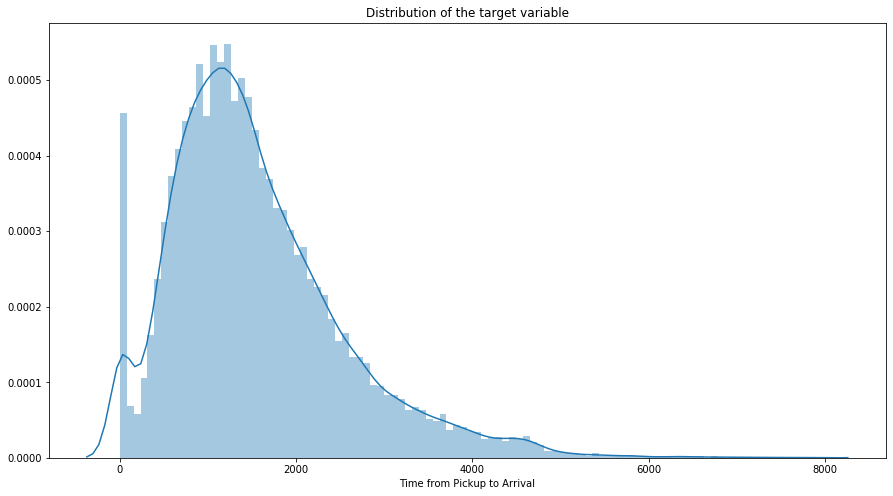

In [187]:
# Check for Normal distribution

plt.figure(figsize=(15,8))
plt.title('Distribution of the target variable')             

sns.distplot(new_data['Time from Pickup to Arrival'],
             bins=100,
             kde=True)

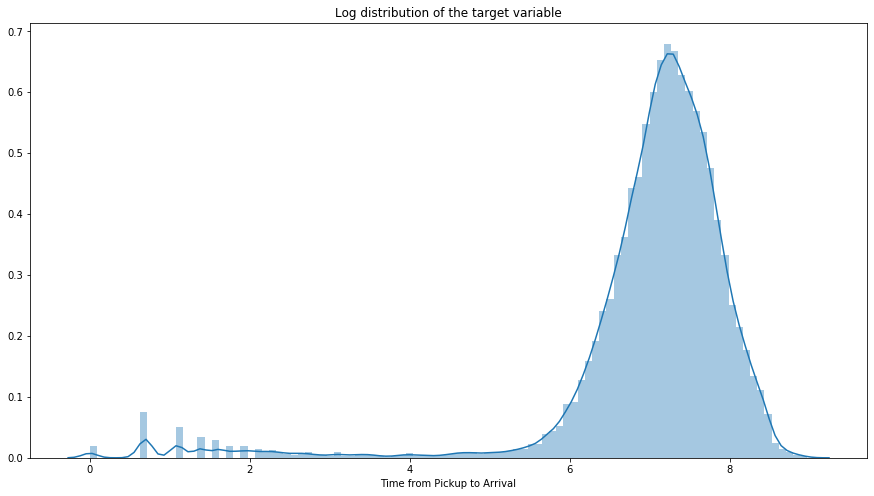

In [188]:
# Normal distribution , Viewed from logarhythmic angle

plt.figure(figsize=(15,8))                                       
plt.title('Log distribution of the target variable')             

sns.distplot(np.log(new_data['Time from Pickup to Arrival']),
             bins=100,
             kde=True)

In [189]:
# Log all values on the target variable

new_data['Time from Pickup to Arrival'] = np.log(new_data['Time from Pickup to Arrival'])

In [190]:
mod_data = new_data[new_data['Time from Pickup to Arrival'] > 5.1]     # Filter Outliars

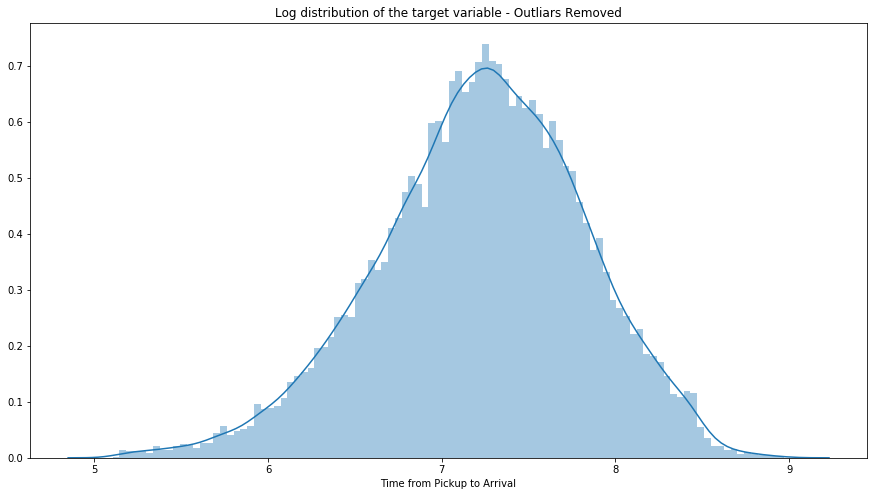

In [191]:
plt.figure(figsize=(15,8))                                       
plt.title('Log distribution of the target variable - Outliars Removed')             

sns.distplot(mod_data['Time from Pickup to Arrival'],
             bins=100,
             kde=True)

In [192]:
# Convert logged values back linear form

mod_data['Time from Pickup to Arrival'] = np.exp(mod_data['Time from Pickup to Arrival'])

C:\Users\Sibonelo.Malakiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [193]:
# Filter the upper bound

mod_data = mod_data[mod_data['Time from Pickup to Arrival'] < 6000 ]     # Filter Outliars , viewing linear graph

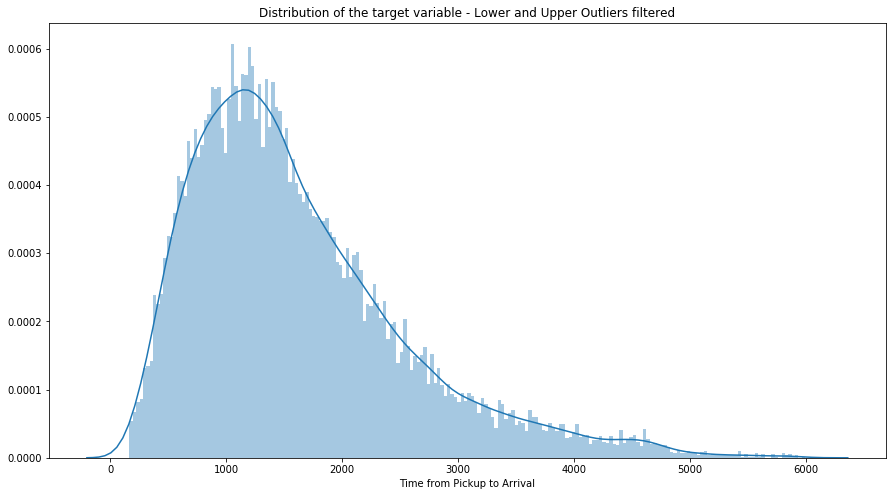

In [194]:
# Plot original dataset without outliars

plt.figure(figsize=(15,8))                                       
plt.title('Distribution of the target variable - Lower and Upper Outliers filtered')             

sns.distplot(mod_data['Time from Pickup to Arrival'],
             bins=200,
             kde=True)

#### Feature selection

In [195]:
# Split the data into X & y ( For Feature Selection )

X = mod_data.drop('Time from Pickup to Arrival', axis = 1).values
X2 = mod_data.drop('Time from Pickup to Arrival', axis = 1)
y = mod_data['Time from Pickup to Arrival'].astype(int)

print(X.shape)
print(y.shape)

(20286, 33)
(20286,)


In [196]:
# Run a Tree-based estimators (i.e. decision trees & random forests)

dt = DecisionTreeClassifier(random_state=15, criterion  = 'entropy', max_depth = 10)
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=15, splitter='best')

In [197]:
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(new_data.drop('Time from Pickup to Arrival', axis = 1)):
    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

In [198]:
# Creating a Feature Importance dataframe for visualisation

fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df


# Ordering the data
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()

fi_df

,index,Feature,Feature Importance
0,9,Distance (KM),0.196884
1,13,Destination Lat,0.054113
2,24,Confirmation - Second,0.052038
3,29,Pickup - Minute,0.048669
4,15,No_Of_Orders,0.047713
5,11,Pickup Lat,0.047351
6,17,Average_Rating,0.044171
7,21,Placement - Second,0.043199
8,12,Pickup Long,0.041048
9,18,No_of_Ratings,0.040220


In [199]:
# Remove all columns without significant impact

columns_to_keep = fi_df['Feature'][0:30]

#### Regression

In [200]:
# Split the data into X & y ( For Linear_Regression )

X = mod_data[columns_to_keep].values
y = mod_data['Time from Pickup to Arrival'].astype(int)

print(X.shape)
print(y.shape)

(20286, 30)
(20286,)


In [201]:
# Create a train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size = 0.2, random_state=15)

In [202]:
# Training on Linear Regression

lm = LGBMRegressor(num_leaves=15, random_state = 15)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_train)

In [203]:
# Accuracy and modelling parameters


print("")
# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,y_pred)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test,lm.predict(X_test))))

print("")
# The R Squared
print('The Accuracy R2  on the training dataset is: ',r2_score(y_train,y_pred) )


The RMSE  on the training dataset is:  670.8134841966348
The RMSE  on the testing dataset is:  691.086421762972

The Accuracy R2  on the training dataset is:  0.48935746558289106


Text(0.5, 1.0, 'Actuals Vs Residuals')

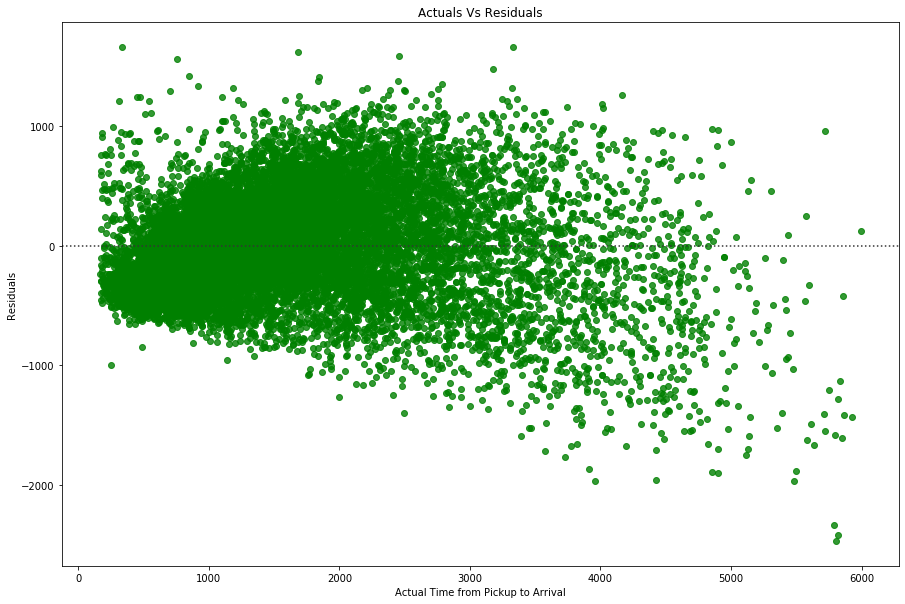

In [204]:
# Ploting Residuals

plt.figure(figsize=(15,10))

sns.residplot(y_train, y_pred, color='green')
plt.xlabel('Actual Time from Pickup to Arrival')
plt.ylabel('Residuals')
plt.title('Actuals Vs Residuals')


#### Make predictions

In [ ]:
y_sub = lm.predict(X_sub)

#### Notes

1. Improve R-Squared and decrease variance of residuals
2. Parameter tuning

#### Prepare submission file

In [ ]:
### Pre-Processing

In [205]:
sub = pd.read_csv('Test_Zindi.csv')
sub_for_zindi = pd.read_csv('SampleSubmission_Zindi.csv')

In [206]:
# Merge sub and riders

data_sub = pd.merge(sub, riders, how='left', left_on='Rider Id', right_on='Rider Id', left_index=True)

In [207]:
# Drop some columns ( Note here we also drop features)

data_sub = data_sub.drop(['Vehicle Type','Precipitation in millimeters' , 'User Id','Order No',
                 'Platform Type','Personal or Business','Rider Id'],axis = 1)      # Drop Precipitation
data_sub = data_sub.fillna(data_sub.mean())   

In [208]:
# Time manipulation application , Note: This is slow , search for alternative implementation

data_sub['Placement - Hour'] = data_sub['Placement - Time'].apply(time_parse_hr)
data_sub['Placement - Minute'] = data_sub['Placement - Time'].apply(time_parse_min)
data_sub['Placement - Second'] = data_sub['Placement - Time'].apply(time_parse_sec)
                                                            
data_sub['Confirmation - Hour'] = data_sub['Confirmation - Time'].apply(time_parse_hr)
data_sub['Confirmation - Minute'] = data_sub['Confirmation - Time'].apply(time_parse_min)
data_sub['Confirmation - Second'] = data_sub['Confirmation - Time'].apply(time_parse_sec)

data_sub['Arrival at Pickup - Hour'] = data_sub['Arrival at Pickup - Time'].apply(time_parse_hr)
data_sub['Arrival at Pickup - Minute'] = data_sub['Arrival at Pickup - Time'].apply(time_parse_min)
data_sub['Arrival at Pickup - Second'] = data_sub['Arrival at Pickup - Time'].apply(time_parse_sec)

data_sub['Pickup - Hour'] = data_sub['Pickup - Time'].apply(time_parse_hr)
data_sub['Pickup - Minute'] = data_sub['Pickup - Time'].apply(time_parse_min)
data_sub['Pickup - Second'] = data_sub['Pickup - Time'].apply(time_parse_sec)

In [209]:
# Drop original times

data_sub = data_sub.drop(['Placement - Time' , 'Confirmation - Time',
                 'Arrival at Pickup - Time' ,'Pickup - Time'],
                 axis = 1)

In [210]:
data_sub.shape

(7068, 30)

In [211]:
data_sub = data_sub[columns_to_keep]     ### Same order as the one used for prediction

In [212]:
X_sub = data_sub.values

In [213]:
y_sub = lm.predict(X_sub)

In [214]:
y_sub

array([1619.0691682 , 1315.08669687, 1524.45763898, ..., 1736.55094461,
       2613.0789386 , 1675.75206032])

In [215]:
order_no = np.array(sub['Order No'])
sub_dict = day_dict = dict(zip(order_no, y_sub))

In [216]:
sub_for_zindi['Time from Pickup to Arrival'] = sub_for_zindi['Order_No'].map(sub_dict)

In [217]:
sub_for_zindi

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,1619.069168
1,Order_No_12736,1315.086697
2,Order_No_768,1524.457639
3,Order_No_15332,1238.360022
4,Order_No_21373,1212.329628
...,...,...
7063,Order_No_3612,1498.543817
7064,Order_No_7657,2835.297031
7065,Order_No_1969,1736.550945
7066,Order_No_10591,2613.078939


In [219]:
sub_for_zindi.to_csv('Submission_file_v_02.csv' , index = False)

In [163]:
# Train using pickle

model = pickle.load(open('sendy_simple_lm_regression.pkl', 'rb'))

In [164]:
prediction = model.predict(X_sub)

In [165]:
prediction

array([1619.0691682 , 1315.08669687, 1524.45763898, ..., 1736.55094461,
       2613.0789386 , 1675.75206032])